### Eulerian autocovariance  filtered and demodulated signal
cf github/zcasparco/equinox_phd/llc4320/signal_filtering_store.ipynb for filtering and demodulation method

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp


from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8701715.datarmor0/parcels-502090/libparcels_random_2133da44-eba7-4255-8413-1ca4bdc5c3f2.so


In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=6)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes 

In [3]:
#Load demodulated field
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_autocov.zarr')
#grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]
ds = ds.chunk({'i':-1,'j':-1})
#ut.load_grd()[['XC', 'YC', 'Depth']]#.persist()
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080, lags: 321)
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
    lat      (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lon      (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    Cri      (face, j, i, lags) float64 dask.array<chunksize=(1, 1080, 1080, 321), meta=np.ndarray>
    Crr      (face, j, i, lags) float64 dask.array<chunksize=(1, 1080, 1080, 321), meta=np.ndarray>

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell 

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12, lags = 0.0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

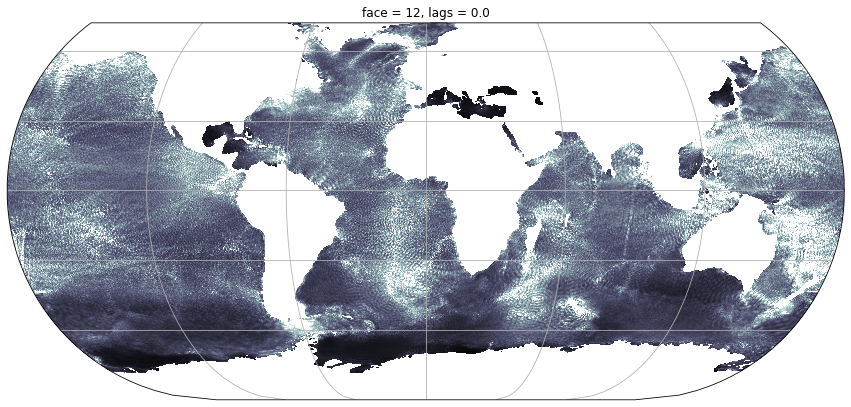

In [7]:
pl.plot_pretty(np.sqrt(ds.Crr.isel(lags=0)), 
                   infer_intervals=True,land=False,cmap='bone',vmax=0.1,colorbar=False
                  )

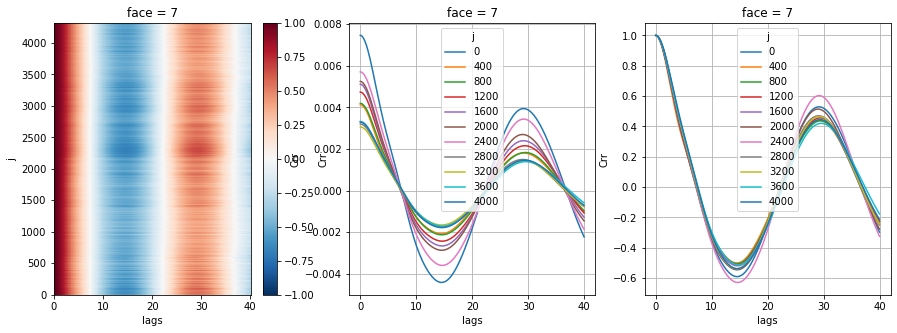

In [8]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
(ds.Crr.mean(['i'])/ds.Crr.mean(['i']).isel(lags=0)).isel(face=7).plot(ax=axs[0])
ds.Crr.mean('i').isel(face=7,j=slice(0,None,100)).plot(hue='j',ax=axs[1])
(ds.Crr.mean('i')/ds.Crr.mean('i').isel(lags=0)).isel(face=7,j=slice(0,None,100)).plot(hue='j',ax=axs[2])
axs[1].grid();axs[2].grid()

In [4]:
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
ds = ds.persist()
#N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
#              bins=[lon_bins, lat_bins], 
#              dim=['i', 'j', 'face']
#             ).persist()


In [5]:
ds = ds.drop(['lon','lat'])

In [6]:
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds = ds.persist()

In [7]:
print(ds.lat.rename('lat'),ds.lon.rename('lon'))

<xarray.DataArray 'lat' (face: 13, j: 1080, i: 1080)>
dask.array<add, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316 <xarray.DataArray 'lon' (face: 13, j: 1080, i: 1080)>
dask.array<add, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4

In [36]:
N = histogram(ds.lat.rename('lat'), bins=[lat_bins], dim=['i', 'j', 'face']
             ).persist()

In [43]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080, lags: 321)
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    Cri      (face, j, i, lags) float64 dask.array<chunksize=(1, 270, 270, 321), meta=np.ndarray>
    Crr      (face, j, i, lags) float64 dask.array<chunksize=(1, 270, 270, 321), meta=np.ndarray>
    lon      (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lat      (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [8]:
histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins,lat_bins])

<xarray.DataArray 'histogram_lon_lat' (lon_bin: 359, lat_bin: 119)>
dask.array<getitem, shape=(359, 119), dtype=int64, chunksize=(359, 119), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin  (lon_bin) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat_bin  (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5

In [9]:
N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

In [58]:
ds.Crr

<xarray.DataArray 'Crr' (face: 13, j: 1080, i: 1080, lags: 321)>
dask.array<rechunk-merge, shape=(13, 1080, 1080, 321), dtype=float64, chunksize=(1, 1080, 1080, 321), chunktype=numpy.ndarray>
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0

In [13]:
ds.Crr

<xarray.DataArray 'Crr' (face: 13, j: 1080, i: 1080, lags: 321)>
dask.array<rechunk-merge, shape=(13, 1080, 1080, 321), dtype=float64, chunksize=(1, 1080, 1080, 321), chunktype=numpy.ndarray>
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0

In [15]:
E = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),
                  bins=[lon_bins, lat_bins], 
                  weights=ds.Crr.isel(lags=0),
                  dim=['i', 'j', 'face']
                 )

E = (E/N).rename('Crr')

In [25]:
ds_binned = xr.concat([(histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins, lat_bins], weights=ds.Crr.isel(lags=i),
                  dim=['i', 'j', 'face']
                 )/N).rename('Crr') for i in range(ds.lags.size)], dim='lags')

In [26]:
ds_binned = ds_binned.assign_coords({'lags':ds.lags})

In [28]:
ds_binned = ds_binned.rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})

In [29]:
ds_binned = ds_binned.persist()

In [30]:
ds_binned.attrs.update({'binsize':dl})

In [33]:
ds_binned = ds_binned.compute()

In [36]:
_ = ds_binned.to_netcdf(path='/home1/datawork/zcaspar/mit4320/binned_Ecov.nc')

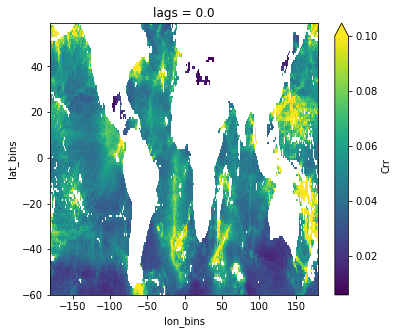

In [38]:
fig,ax = plt.subplots(figsize=(6,5))
np.sqrt(ds_binned.isel(lags=0)).plot(vmax=0.1,y='lat_bins',ax=ax)

In [39]:
#client.restart()
#
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job al